In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import emcee
import torch
import sacc
import corner
import os
import itertools
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import qmc
import arviz as az  # ArviZ is useful for MCMC diagnostics
import matplotlib.pyplot as plt
from matplotlib import colors
import arviz as az
import seaborn as sns

from copy import deepcopy

import src.training as training
import src.models as models

from multiprocessing import Pool, cpu_count
from time import time
from importlib import reload
reload(training)
reload(models)

seed = 14
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.use_deterministic_algorithms(False)

# set matplotlib plotting style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['cmr10']
plt.rcParams['mathtext.fontset'] ='cm'
plt.rcParams['figure.facecolor'] = 'white'
plt.rc('axes', unicode_minus=False)
plt.rc('axes.formatter', use_mathtext=True)

# set device for all tensors
device = 'cuda'

In [8]:
import pyccl as ccl

cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, A_s=5.0e-9, n_s=0.96)
print(cosmo.sigma8())

1.2964856446788608


In [ ]:
# Load in mcmc data sets

# load in the data
numerical_reader = emcee.backends.HDFBackend('mcmc/76walkers_chain_outputs.h5', read_only=True)
pretrain_reader = emcee.backends.HDFBackend('mcmc/76_pretrain_emulator_mcmc_100tau.h5', read_only=True)
fresh_reader = emcee.backends.HDFBackend('mcmc/76_fresh_emulator_mcmc_100tau.h5', read_only=True)
maml_reader = emcee.backends.HDFBackend('mcmc/76_maml_emulator_mcmc_100tau.h5', read_only=True)

# # Save numerical data to new file without blobs
# numerical_chain = numerical_reader.get_chain()
# numerical_log_prob = numerical_reader.get_log_prob()
# numerical_acceptance = numerical_reader.get_blobs()
# fname = 'mcmc/76walkers_chain_outputs_no_blobs.h5'
# with h5.File(fname, 'w') as f:
#     f.create_dataset('chain', data=numerical_chain)
#     f.create_dataset('log_prob', data=numerical_log_prob)
#     f.create_dataset('acceptance', data=numerical_acceptance)

In [ ]:
# Print max autocorr length
print('Numerical max autocorr length:', np.max(numerical_reader.get_autocorr_time()))
print('Pretrain max autocorr length:', np.max(pretrain_reader.get_autocorr_time()))
print('Fresh max autocorr length:', np.max(fresh_reader.get_autocorr_time()))
print('MAML max autocorr length:', np.max(maml_reader.get_autocorr_time()))

Numerical max autocorr length: 336.76557547468536
Pretrain max autocorr length: 459.18805197613705
Fresh max autocorr length: 527.979634538277
MAML max autocorr length: 537.4069682709757


In [ ]:
# def calculate_ESS(reader):
#     tau = reader.get_autocorr_time()
#     n_walkers, n_samples, n_dim = reader.get_chain().shape
#     ess = (n_samples * n_walkers) / (1 + 2 * np.sum(tau))
#     return ess

# print('Numerical ESS:', calculate_ESS(numerical_reader))
# print('Pretrain ESS:', calculate_ESS(pretrain_reader))
# print('Fresh ESS:', calculate_ESS(fresh_reader))
# print('MAML ESS:', calculate_ESS(maml_reader))

In [ ]:
numerical_samples = numerical_reader.get_chain(discard=2000, thin=1, flat=True)[:,:5]
pretrain_samples = pretrain_reader.get_chain(discard=2000, thin=1, flat=True)[:,:5]
fresh_samples = fresh_reader.get_chain(discard=2000, thin=1, flat=True)[:,:5]
maml_samples = maml_reader.get_chain(discard=2000, thin=1, flat=True)[:,:5]

# Compute Rhat
# num_rhat = az.rhat(numerical_samples)
# pretrain_rhat = az.rhat(pretrain_samples)
# fresh_rhat = az.rhat(fresh_samples)
# maml_rhat = az.rhat(maml_samples)

# print('Numerical Rhat:', num_rhat)
# print('Pretrain Rhat:', pretrain_rhat)
# print('Fresh Rhat:', fresh_rhat)
# print('MAML Rhat:', maml_rhat)

In [ ]:
# Combine Omega_c and Omega_b to Omega_m
Omega_m = numerical_samples[:,0] + numerical_samples[:,1]
numerical_samples = np.concatenate((Omega_m[:,None], numerical_samples[:,2:]), axis=1)

Omega_m = pretrain_samples[:,0] + pretrain_samples[:,1]
pretrain_samples = np.concatenate((Omega_m[:,None], pretrain_samples[:,2:]), axis=1)

Omega_m = fresh_samples[:,0] + fresh_samples[:,1]
fresh_samples = np.concatenate((Omega_m[:,None], fresh_samples[:,2:]), axis=1)

Omega_m = maml_samples[:,0] + maml_samples[:,1]
maml_samples = np.concatenate((Omega_m[:,None], maml_samples[:,2:]), axis=1)

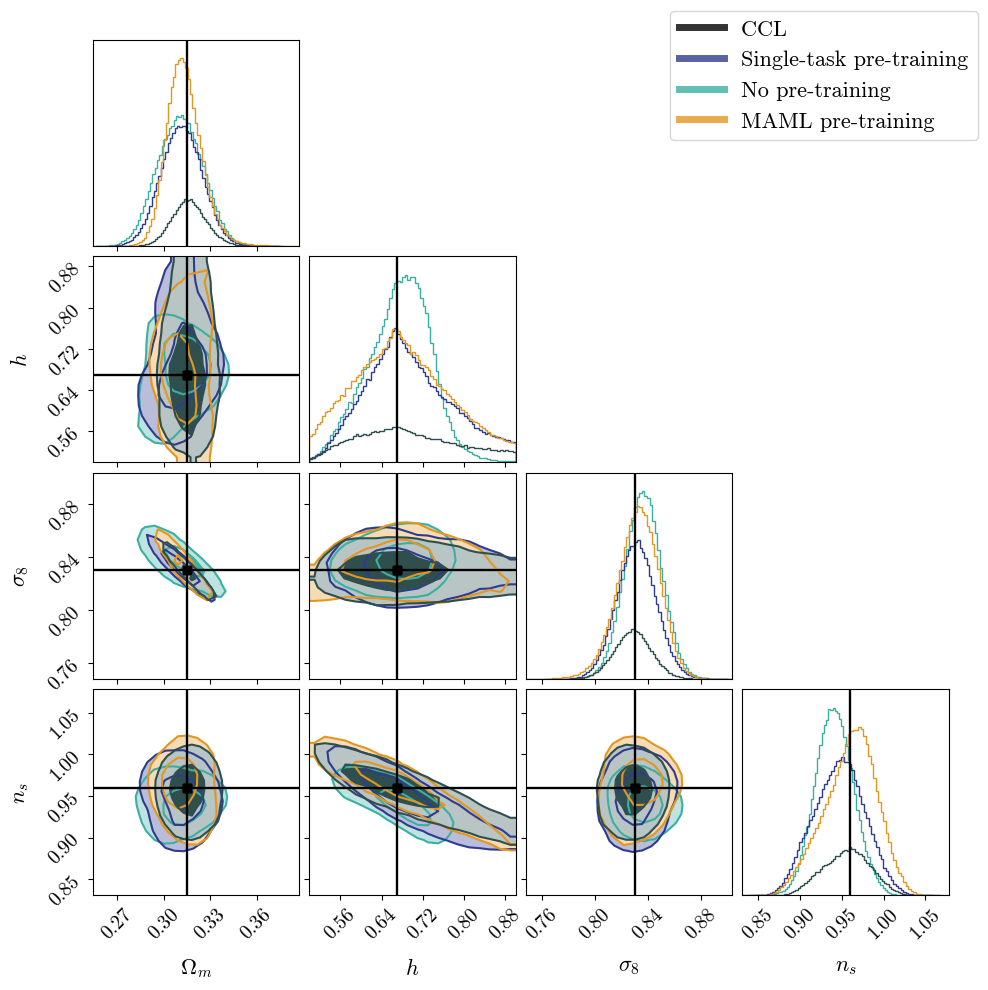

In [ ]:

theta_fid = np.array([0.27+0.045, 0.67, 0.83, 0.96])
param_ranges = None #[(0.22, 0.4), (0.2, 1.2), (0.76, 0.9), (0.8, 1.1)]
smooth = 0.02
bins = 20
hist_factor = 4
levels = [0.393, 0.865]

colors_pop = ["#2F3B8F", "#3AB0A2", "#E39620"]

labels = [r"$\Omega_m$", r"$h$", r"$\sigma_8$", r"$n_s$", r"$\delta^z_1$", r"$\delta^z_2$", ]

fig = plt.figure(figsize=(10, 10))

# Add fresh samples
corner.corner(
    fresh_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    color=colors_pop[1],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Add emulator samples
corner.corner(
    pretrain_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    color=colors_pop[0],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Add MAML samples
corner.corner(
    maml_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    color=colors_pop[2],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    fig=fig
)

# Plot the corner plot
corner.corner(
    numerical_samples, 
    labels=labels[:4], 
    truths=theta_fid,
    levels=levels,
    plot_datapoints=False,
    fill_contours=True,
    plot_density=False,
    color='darkslategray',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    label_kwargs={'fontsize': 16},
    fig=fig
)

handles = [
    plt.Line2D([0], [0], color='k', lw=5, alpha=0.8, label='CCL '),
    plt.Line2D([0], [0], color=colors_pop[0], lw=5, alpha=0.8, label='Single-task pre-training'),
    plt.Line2D([0], [0], color=colors_pop[1], lw=5, alpha=0.8, label='No pre-training'),
    plt.Line2D([0], [0], color=colors_pop[2], lw=5, alpha=0.8, label='MAML pre-training')
]

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=14)

fig.legend(handles=handles, loc='upper right', fontsize=16)
plt.savefig('mcmc/mcmc_compare_emulators.pdf', bbox_inches='tight', dpi=300)

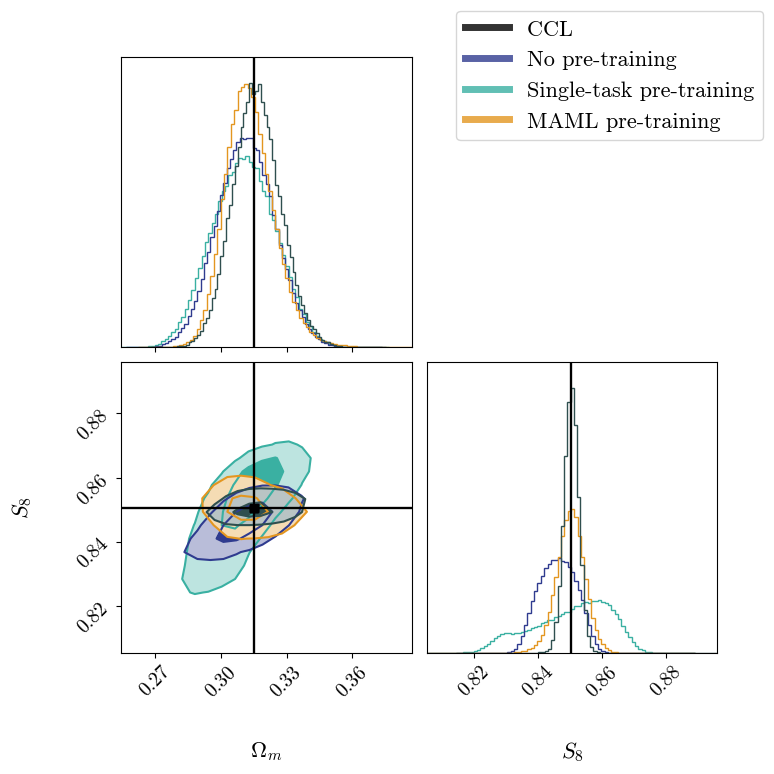

In [ ]:
# Compute S8 values for each chain
def compute_S8(Omega_m, sigma8):
    return sigma8 * (Omega_m / 0.3)**0.5

S8_numerical = compute_S8(numerical_samples[:,0], numerical_samples[:,2])
S8_num_samples = np.vstack((numerical_samples[:,0], S8_numerical)).T

S8_pretrain = compute_S8(pretrain_samples[:,0], pretrain_samples[:,2])
S8_pretrain_samples = np.vstack((pretrain_samples[:,0], S8_pretrain)).T

S8_fresh = compute_S8(fresh_samples[:,0], fresh_samples[:,2])
S8_fresh_samples = np.vstack((fresh_samples[:,0], S8_fresh)).T

S8_maml = compute_S8(maml_samples[:,0], maml_samples[:,2])
S8_maml_samples = np.vstack((maml_samples[:,0], S8_maml)).T

truths = [theta_fid[0], compute_S8(theta_fid[0], theta_fid[2])]
levels = [0.393, 0.865]
smooth = 0.02
bins = 20
hist_factor = 4
param_ranges = None
fill = True

fig = plt.figure(figsize=(8, 8))

colors=['#4059AD', '#97D8C4', '#F4B942']
colors_pop = ["#2F3B8F", "#3AB0A2", "#E39620"]

# Add fresh samples
corner.corner(
    S8_fresh_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[1],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Add emulator samples
corner.corner(
    S8_pretrain_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[0],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Add MAML samples
corner.corner(
    S8_maml_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color=colors_pop[2],
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    hist_kwargs=dict(density=True),
    range=param_ranges,
    fig=fig
)

# Plot the corner plot
corner.corner(
    S8_num_samples, 
    labels=[r"$\Omega_m$", r"$S_8$"], 
    truths=truths,
    levels=levels,
    plot_datapoints=False,
    fill_contours=fill,
    plot_density=False,
    color='darkslategray',
    truth_color='k',
    smooth=smooth,
    bins=bins,
    hist_bin_factor=hist_factor,
    range=param_ranges,
    label_kwargs={'fontsize': 16},
    hist_kwargs=dict(density=True),
    fig=fig
)

handles = [
    plt.Line2D([0], [0], color='k', lw=5, alpha=0.8, label='CCL '),
    plt.Line2D([0], [0], color=colors_pop[0], lw=5, alpha=0.8, label='No pre-training'),
    plt.Line2D([0], [0], color=colors_pop[1], lw=5, alpha=0.8, label='Single-task pre-training'),
    plt.Line2D([0], [0], color=colors_pop[2], lw=5, alpha=0.8, label='MAML pre-training')
]

for ax in fig.axes:
    ax.tick_params(axis='both', labelsize=14)

fig.legend(handles=handles, loc='upper right', fontsize=16)

#plt.savefig('plots/S8_compare_emulators.pdf', bbox_inches='tight', dpi=300)

- Remove lines in 1D distributions (but keep truth line)
- Make tick labels and axis labels bigger
- Try using unfilled contours
- Try using just unfilled for non-MAML

In [ ]:
# import numpy as np
# import scipy.stats as stats

# def compute_summary_stats(samples_emul, samples_fid, theta_fid):
#     """
#     Compute summary statistics comparing emulator MCMC posterior to fully computed posterior.

#     Parameters:
#     - samples_emul: (n_samples, n_params) array of emulator posterior samples
#     - samples_fid: (n_samples, n_params) array of fiducial posterior samples
#     - theta_fid: (n_params,) array of fiducial parameter values

#     Returns:
#     - Dictionary with bias, standard deviation ratio, posterior volume ratio, credible interval overlap, and KL divergence.
#     """
    
#     # Compute means and standard deviations
#     theta_emul_mean = np.mean(samples_emul, axis=0)
#     theta_fid_mean = np.mean(samples_fid, axis=0)

#     sigma_emul = np.std(samples_emul, axis=0, ddof=1)
#     sigma_fid = np.std(samples_fid, axis=0, ddof=1)

#     # Compute bias metrics
#     bias = theta_emul_mean - theta_fid
#     relative_bias = bias / sigma_fid  # Relative to fiducial uncertainty

#     # Compute constraining power metrics
#     sigma_ratio = sigma_emul / sigma_fid  # Ratio of standard deviations
#     posterior_volume_ratio = np.prod(sigma_ratio)  # Multidimensional volume ratio

#     # Compute credible interval overlap (assumes Gaussian approximation)
#     overlap = np.mean((theta_fid > (theta_emul_mean - sigma_emul)) & 
#                       (theta_fid < (theta_emul_mean + sigma_emul)))

#     # Compute KL divergence
#     kl_div = np.sum(stats.gaussian_kde(samples_emul.T).logpdf(samples_fid.T) - 
#                     stats.gaussian_kde(samples_fid.T).logpdf(samples_fid.T))

#     return {
#         "bias": bias,
#         "relative_bias": relative_bias,
#         "sigma_ratio": sigma_ratio,
#         "posterior_volume_ratio": posterior_volume_ratio,
#         "credible_interval_overlap": overlap,
#         "KL_divergence": kl_div
#     }

# # Example usage
# # Assume `samples_emul` and `samples_fid` are loaded from MCMC chains

# results = compute_summary_stats(maml_samples, numerical_samples, theta_fid)
# print(results)

# results = compute_summary_stats(pretrain_samples, numerical_samples, theta_fid)
# print(results)